# Imports and Data

In [3]:
import glob
import skimage.io
import numpy as np
import pandas as pd
import sklearn.model_selection
import numpy as np
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
# from skimage.feature import greycomatrix, greycoprops
from skimage.util import img_as_ubyte

import scipy.stats
from skimage.transform import rescale, resize, downscale_local_mean

from colour import *

#domain1 = glob.glob('C:/snec_data/Result_Data/cirrus/enface/*_cube_z.tif')
#domain2 = glob.glob('C:/snec_data/Result_Data/plex/enface/*_cube_z.tif')
#domain3 = glob.glob('C:/Users/Prinzessin/projects/image_data/iChallenge_AMD_OD_Fovea_lesions/images_AMD/*.jpg')
# domain2 = glob.glob('C:/Users/Prinzessin/projects/image_data/iChallenge_AMD_OD_Fovea_lesions/images_Non-AMD/*.jpg')

dev_mode = True

if dev_mode:
    domain1 = glob.glob('C:/Users/Prinzessin/projects/image_data/drac_oct/DR/images/train/*')[0:10]
    domain2 = glob.glob('C:/Users/Prinzessin/projects/image_data/OCTA-500/OCTA_3M/Projection Maps/OCT(FULL)/*')[0:10]
    domain3 = glob.glob('C:/Users/Prinzessin/projects/image_data/iChallenge_AMD_OD_Fovea_lesions/images_AMD/*.jpg')[0:10]
    domain1_name = "DRAC"
    domain2_name = "OCTA-500"
    domain3_name = "Fundus"
else: 
    domain1 = glob.glob("E:/Christina/Result_Data/CIRRUS_Normal/enface/*_cube_z.tif")
    domain2 = glob.glob("E:/Christina/Result_Data/PLEX_*/enface/*/*_cube_z.tif")        
    domain3 = glob.glob("E:/Christina/Result_Data/ADAM_*/fundus/*jpg")
    domain1_name = "CIRRUS"
    domain2_name = "PLEX"
    domain3_name = "Fundus"

# Feature Analysis

In [117]:

features1 = []
features2 = []
features3 = []

def get_features(img, label=None):
    
    glcm = graycomatrix(img, distances=[1], 
                           angles=[0], symmetric=True, 
                           normed=True)
    
    # print(scipy.stats.describe(glcm.flatten()))
    
    # print(graycoprops(glcm, "contrast")[0][0].type)
        
    feature = {"contrast" :  graycoprops(glcm, "contrast")[0][0],
               "dissimilarity" : graycoprops(glcm, "dissimilarity")[0][0],
               "homogeneity" : graycoprops(glcm, "homogeneity")[0][0],
               "ASM" : graycoprops(glcm, "ASM")[0][0],
               "energy" :  graycoprops(glcm, "energy")[0][0],
               "correlation" : graycoprops(glcm, "correlation")[0][0],
               "kurtosis" : scipy.stats.kurtosis(glcm.flatten()),
               "skew" : scipy.stats.skew(glcm.flatten()),
               "mean img" :  np.mean(img),
               "label" : label
                }    
    
    return feature

for path in domain1:
    if dev_mode:
        image = skimage.io.imread(path, as_gray=True)
        image = img_as_ubyte(image)
    else:
        image = skimage.io.imread(path, plugin='pil')
        
    features1.append(get_features(image, label=1))
    
   
print("done domain 1")    

for path in domain2:
    if dev_mode:
        image = skimage.io.imread(path, as_gray=True)
        image = img_as_ubyte(image)
    else:
        image = skimage.io.imread(path, plugin='pil')
    
    features2.append(get_features(image, label=2))
    
print("done domain 2")    

for path in domain3:
    image = skimage.io.imread(path, as_gray=True)
    image = img_as_ubyte(image)
    
    features3.append(get_features(image, label=3))
    
print("done domain 3")    
    


done domain 1
done domain 2
done domain 3


In [118]:
df = pd.DataFrame(features1 + features2 + features3)
features_train, features_test, gt_train, gt_test = sklearn.model_selection.train_test_split( df.loc[:, df.columns != "label"], df["label"], test_size=0.33, random_state=42)

print(df.shape)
print(df.info())
print(df.head(2))
print(features_train.head(2))
print(gt_train.head(2))

(30, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   contrast       30 non-null     float64
 1   dissimilarity  30 non-null     float64
 2   homogeneity    30 non-null     float64
 3   ASM            30 non-null     float64
 4   energy         30 non-null     float64
 5   correlation    30 non-null     float64
 6   kurtosis       30 non-null     float64
 7   skew           30 non-null     float64
 8   mean img       30 non-null     float64
 9   label          30 non-null     int64  
dtypes: float64(9), int64(1)
memory usage: 2.5 KB
None
     contrast  dissimilarity  homogeneity       ASM    energy  correlation  \
0  623.363582      18.312276     0.076741  0.000169  0.013005     0.905994   
1  681.259985      19.148088     0.072928  0.000140  0.011817     0.895053   

       kurtosis        skew   mean img  label  
0  21327.476587  111.4

## Random Forest

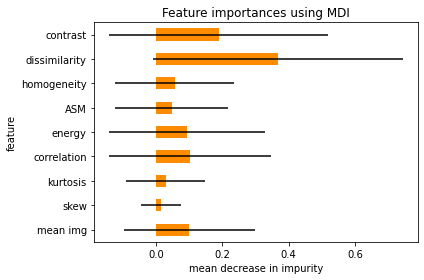

In [129]:
rf = RandomForestRegressor(random_state=0)

rf.fit(features_train, gt_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=std, ax=ax, color="darkorange")
plt.gca().invert_yaxis()

ax.set_title("Feature importances using MDI")
ax.set_ylabel("feature")
ax.set_xlabel("mean decrease in impurity")
fig.tight_layout()

In [127]:
features_test.columns

Index(['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy',
       'correlation', 'kurtosis', 'skew', 'mean img'],
      dtype='object')

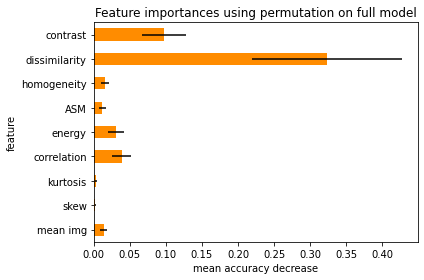

In [128]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, features_test, gt_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=features_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std, ax=ax, color="darkorange")
plt.gca().invert_yaxis()

ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("mean accuracy decrease")
ax.set_ylabel("feature")
fig.tight_layout()
plt.show()

0      6761.076156
1       152.478519
2         7.921892
3         0.786178
4         2.988449
5         0.055409
6    580077.154074
7      1923.193669
8       731.533744
Name: chi2_score, dtype: float64
0     0.000000e+00
1     7.757294e-34
2     1.904508e-02
3     6.749686e-01
4     2.244226e-01
5     9.726757e-01
6     0.000000e+00
7     0.000000e+00
8    1.410801e-159
Name: p_value, dtype: float64


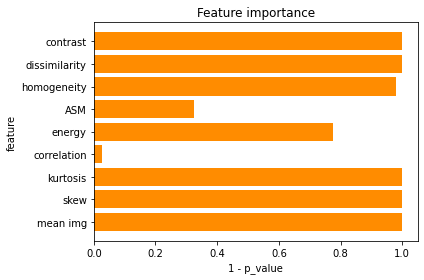

In [122]:
# import packages
import pandas as pd

# import data
my_df = df.copy()

from sklearn.feature_selection import SelectKBest, chi2

X = my_df.drop(["label"], axis = 1)
y = my_df["label"]

feature_selector = SelectKBest(chi2, k = "all")
fit = feature_selector.fit(X,y)

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_variable_names = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "chi2_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["chi2_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
X_new = X[selected_variables]

#print(X_new)


# forest_importances = pd.DataFrame(summary_stats["p_value"].flatten(), columns=features_test.columns)

forest_importances = summary_stats["p_value"].reindex(index=features_test.columns)

index = features_test.columns

forest_importances = pd.DataFrame({'p_value': list(summary_stats["p_value"].sort_index())}, index=index)

print(summary_stats["chi2_score"].sort_index())
print(summary_stats["p_value"].sort_index())


fig, ax = plt.subplots()
ax.barh(features_test.columns, 1 - summary_stats["p_value"].sort_index(), color="darkorange") # yerr=result.importances_std
plt.gca().invert_yaxis()
ax.set_title("Feature significance")
ax.set_xlabel("1 - p_value")
ax.set_ylabel("feature")

fig.tight_layout()
plt.show()

## Correlation Matrix

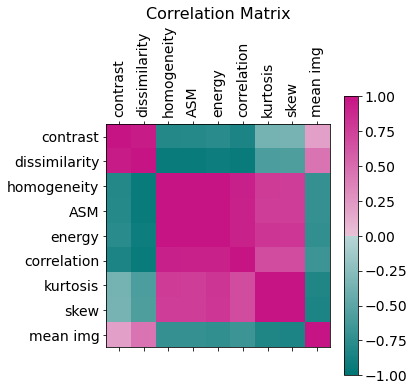

In [123]:
f = plt.figure(figsize=(5, 5))
plt.matshow(features_train.corr(), fignum=f.number, cmap=variint_map, vmin=-1, vmax=1)
plt.xticks(range(features_train.select_dtypes(['number']).shape[1]), features_train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_train.select_dtypes(['number']).shape[1]), features_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.tight_layout()
plt.savefig("example_results/correlation.png", dpi=1200)

## Plotting 2 features

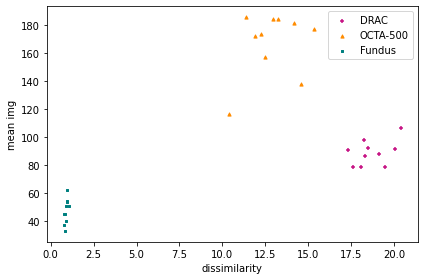

In [124]:

key_x = "dissimilarity"
key_y = "mean img"

# key_x = "contrast"
# key_y = "kurtosis"

x1 = df[df['label'] == 1][key_x]
y1 = df[df['label'] == 1][key_y]

x2 = df[df['label'] == 2][key_x]
y2 = df[df['label'] == 2][key_y]

x3 = df[df['label'] == 3][key_x]
y3 = df[df['label'] == 3][key_y]

plt.figure()
plt.xlabel(key_x)
plt.ylabel(key_y)
plt.scatter(x1, y1, label=domain1_name, color='mediumvioletred', s=10, marker='+')
plt.scatter(x2, y2, label=domain2_name, color='darkorange', s=10, marker='^')
plt.scatter(x3, y3, label=domain3_name, color='teal', s=7, marker=',')
plt.legend()
plt.tight_layout()
plt.savefig("example_results/domainshift.png", dpi=1200)

# Mean and average images
* https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [9]:
def img2np(paths, size = (150, 150)):
    # making n X m matrix
    # iterating through each file

    images = []
    current_image = None
    
    for i, path in enumerate(paths):  
        current_image = skimage.io.imread(path, as_gray=True, plugin='pil')
        current_image = resize(current_image, size, anti_aliasing=True)
        images.append(current_image)
        stacked = np.stack(images, axis=-1)  
    
    return stacked

def find_mean_img(full_mat, title, f):
    # calculate the average
    result = np.mean(full_mat, axis = 2)
    
    f.imshow(result, cmap='gray')
    f.set_title(f'Mean {title}')
    f.axis('off')
    return result

def find_std_img(full_mat, title, f):
    # calculate the standard deviation
    result = np.std(full_mat, axis = 2)

    f.imshow(result, cmap='gray')
    f.set_title(f'Std {title}')
    f.axis('off')
    return result

In [10]:
# run it on our folders
domain1_images = img2np(domain1)
print("done 1")
domain2_images = img2np(domain2)
print("done 2")
domain3_images = img2np(domain3)
print("done 3")

done 1
done 2
done 3


## Plot mean

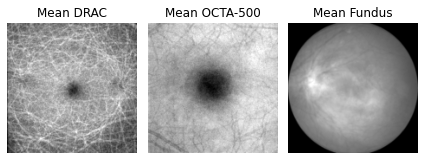

In [11]:
fig, axs = plt.subplots(1, 3)
mean1 = find_mean_img(domain1_images, domain1_name, axs[0])
mean2 = find_mean_img(domain2_images, domain2_name, axs[1])
mean3 = find_mean_img(domain3_images, domain3_name, axs[2])
fig.tight_layout()
fig.savefig(f"example_results/domain_shift_mean.png", dpi=1200)


## Plot absolute mean difference

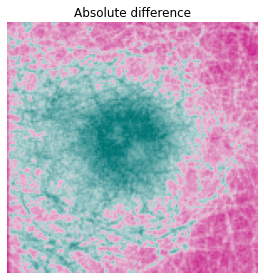

In [15]:
contrast_mean = np.absolute(mean1 - mean2)
# contrast_mean = cv2.absdiff(plex_mean, cirrus_mean)
#contrast_mean = plex_mean * cirrus_mean

plt.imshow(contrast_mean, cmap=variint_map)
plt.title(f'Absolute difference')
plt.axis('off')
plt.tight_layout()
plt.savefig(f"example_results/domain_shift_diff_mean.png", dpi=1200)


## Plot standard dev

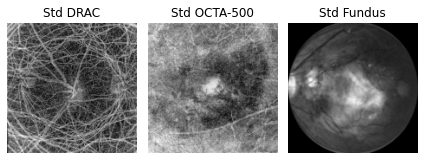

In [13]:
fig, axs = plt.subplots(1, 3)
std1 = find_std_img(domain1_images, domain1_name, axs[0])
std2 = find_std_img(domain2_images, domain2_name, axs[1])
std3 = find_std_img(domain3_images, domain3_name, axs[2])
fig.tight_layout()
fig.savefig(f"example_results/domain_shift_std.png", dpi=1200)
